# Data Dependence

Last week you learned the power of algorithm analysis. This week you learned how to use hardware performance tools to exploit even more powerful optimizations. Today we are going learn about loop optimizations. This type of analysis is specially powerful when dealing with scientific computing, the type of computing used for Machine Learning, Cryptography, Numerical computing, etc.

Let's remember our loop from last session:

In [8]:
from numba import jit, njit, prange
import numpy as np
@njit(parallel=True)
def prange_dep_test(A):
    s = 0
    B=np.copy(A)
    # Without "parallel=True" in the jit-decorator
    # the prange statement is equivalent to range
    for i in prange(1,B.shape[0]-1):
        B[i]=B[i]+B[i+1]*B[i-1]
        s += B[i]
    return s
def range_dep_test(A):
    s=0
    B=np.copy(A)
    for i in range(1,B.shape[0]-1):
        B[i]=B[i]+B[i+1]*B[i-1]
        s += B[i]
    return s

In [17]:
B=np.random.rand(1000)

In [10]:
prange_dep_test(B)

758.4462514693737

In [11]:
range_dep_test(B)

1009.9344694314955

The result is not the smae because there's a dependence in the line B\[i]=B[i]+B[i+1]*B[i-1], let's see how this works.

Imagine the array B as such:


<img src="images/5.3%20Array.png">

At iteration i=1, our line of code will try to access B\[0] and B[2]

<img src="images/5.3%20Array%20with%20dependence.png">

If you notice carefully, by the time B\[2] runs, B[1] has changed. However, if a parallel process runs B[2] before B[1] finishes, then the result will be different. We call this type of relationship DATA DEPENDENCE and we actually have three dependencies present in that single line of code:

## Write after Read 

Write after Read (WAR) happens whenver a variable is written after it is read. For example:

Y=X+1

X=2


This is a WAR dependence because X is read and then written. In our code we have 2 WAR dependencies, first the B[1]=B[1] part. Index one has to be read and then gets written. We represent that dependence as such: 

<img src="images/5.3%20WAR.png">

Another WAR dependency is in the B\[i]=...+B[i+1]..., since B[i+1] is read and then written in the following iteration. We represent that dependence as such: 

<img src="images/5.3%20Array.png">images/5.3%20WAR2.png](attachment:5.3%20WAR2.png)

WAR dependence is also known as Anti-dependence or Forward dependence. It can easily be dealt with by copying the data from  B into a temporrary array and read from there. That will allow for full parallelism.

## Read After Write

Also known as RAW, Flow dependence, True dependence, Backwards dependence, and the mother of dependencies, breaker of loops, the unbroken, rightful Queen of all four dependencies. This is the most problematic and bothersome type of dependency. It happens when a variable is read after it is written, and it is usually impossible to deal with. For example:

X=2

Y=X+1

You definitely can't execute the second statement without the first, and you cannot create a temporary array that holds X's value since you don't know what the new value is going to be.

In our current loop, this dependence is present at the B\[i]=..*B[i-1] and it is represented as such:

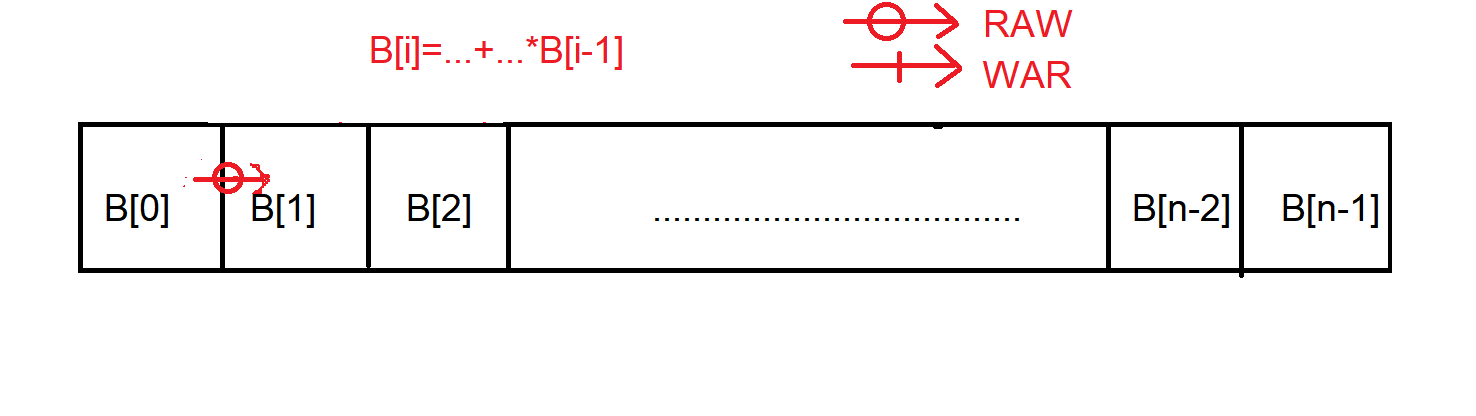

By now you should have figured out that there are two other dependencies for this group. You are partially correct, in third we have:

## Write After Write

Also known as WAW and Output Dependence, this happens when a variable is written after it is written. For example:

1. B = 3
2. A = B + 1
3. B = 7

B is written, then there's a RAW dependence between 1 and 2, and finally B get's rewritten. We don't have this type of dependence in our loop, and usually they don't cause much trouble unless there are other types of dependencies in between. If we remove line 2, the line 1 becomes useless as well.

## Read after Read

RAR is not really a dependence per se, it is much less relevant than WAW and will not impede parallelism whatsoever. For example:

1. A=B
2. C=B

B is read twice, you can run both instructions in whichever order you desire.

So we have covered all bases right?, no, there's is a fifth type of dependency, not part of this group of four, and is called:

## Control dependence

Control dependence is the type of dependence that happens specifically when an instruction depends on the outcome of another instruction for it to run. For example:

1.         if (a == b)
2.             a = a + b
3.         b = a + b

Line 2 depends on the outcome of line 1. We say that 2 has a control dependence on 1. Line 3 has no control dependence regardless what the outcome is, but it has a RAW dependence on 2 (and that is the bad one). Therefore, these statements depend completely on 1 to determine if they can be parallelized or not.

There is a lot more information we could cover about dependencies, but I don't want to bore you. Instead, let's look at some of the ways we can deal with them.

# Loop transformations

Loop transformation is an optimization technique that allows us to deal with dependencies as well as optimize memory and CPU usage of our loops. There are 13 commonly know transformations, but today we will learn the simpler ones that you can implement on your own.

## Loop invariant code motion

This is the simplest optimization in our list. It basically looks for statements that have no effect in the result of the executing loop. For example:

In [18]:
x=0
y=0
C=np.copy(B)
for i in range(1,B.shape[0]-1):
    C[i]=B[i]+B[i+1]*B[i-1]
    x=B[2]
    y += B[i]
print (y)
print (x)

499.4515580976372
0.3514787023296213


Could be rewritten as:

In [19]:
x=0
y=0
for i in range(1,B.shape[0]-1):
    C[i]=B[i]+B[i+1]*B[i-1]
    y += B[i]
x=B[2]
print (y)
print (x)

499.4515580976372
0.3514787023296213


That is because x=B\[2] will be the same even if we execute it outside the loop.
## Loop fission / Distribution
Here we decompose the loop(s) into several loops. This tranformation may allow us to parallelize at least one of the loops. Therefore, the overall performance of the program should improve. Before looking into the example, let's build a function that will check that the output of the loop is the same. We call this function checksum:

In [37]:
def checksum(array, N):
    checksum = 0
    for i in range(N):
        for j in range(N):
            checksum += array[i][j]
    print("Checksum: ", checksum)
    return

N = 2000
A = np.zeros((N,N))
B = np.zeros((N,N))
C = np.random.rand(N,N)
D = np.random.rand(N,N)

In [56]:

def loop1(N,A,B,C,D):
    for i in range(1,N):
        for j in range(1,N):
            A[i][j] = C[i][j] + D[i][j]  # Statement 1
            B[i][j] = A[i-1][j-1]*2.0    # Statement 2: (i,j) dependent on (i-1,j-1) - Can't be parallelized
    return B

In [57]:
%%time
B=loop1(N,A,B,C,D)

Wall time: 7.34 s


In [58]:
checksum(B,N) # check output

Checksum:  7985575.948992513


In [59]:

# But this can be distributed

def loop1_dist(N,A,B,C,D):
    for i in range(1,N):
        for j in range(1,N):
            A[i][j] = C[i][j] + D[i][j]  # Statement 1 - Can be parallelized
        
    for i in range(1,N):
        for j in range(1,N):      
            B[i][j] = A[i-1][j-1]*2.0    # Statement 2: Can be parallelized
    return B

In [60]:
%%time
B=loop1_dist(N,A,B,C,D)

Wall time: 7.27 s


In [61]:
checksum(B,N) # check output again

Checksum:  7985575.948992513


## Loop reversal

This is another simple transformation that can help expose parallelism. It means that we can reverse the order of the loop to get rid of some kind of dependencies. You need to be very careful not to perform this transformation illegally. For example:

In [62]:
def loop2(N,A,B,C,D):
    for i in range(1,N):
        for j in range(1,N):
            A[i][j] = C[i][j] + D[i][j]  # Statement 1
            B[i][j] = A[i][j]*2.0   
    return B

In [63]:
B=loop2(N,A,B,C,D)
checksum(B,N)

Checksum:  7993501.31322485


In [66]:
def loop2_reversed(N,A,B,C,D):
    for i in range(N-1,0,-1):
        for j in range(1,N):
            A[i][j] = C[i][j] + D[i][j]  # Statement 1
            B[i][j] = A[i][j]*2.0   
    return B

In [67]:
B=loop2_reversed(N,A,B,C,D)
checksum(B,N)

Checksum:  7993501.31322485


Both loops are the same (notice the difference in ranges). However, if there is cross dependence, this will fail.

## Loop permutation / Interchange

This transformation consists in exchanging the inner loop for the outer loop. For example:



In [74]:
A = np.copy(C) # Copy original C into A

In [75]:
%%time
for i in range(N-1):                   # Can't be parallelized
    for j in range(N-1):               # Can be parallelized 
        C[i+1][j] = C[i][j] * D[i][j]  # Statement 1: (i+1,j) dependent on (i,j)

Wall time: 5.1 s


In [76]:
checksum(C,N) # check output

Checksum:  2944.474993104796


In [77]:
C = np.copy(A) # Get original C values

In [78]:
%%time
for j in range(N-1):                   # Can be parallelized
    for i in range(N-1):               # Can't be parallelized 
        C[i+1][j] = C[i][j] * D[i][j]  # Statement 1: (i+1,j) dependent on (i,j)

Wall time: 5.28 s


In [79]:
checksum(C,N) # check output again

Checksum:  2944.474993104796


This transformation can be done as long as there is no flow dependence in both dimensions (for 2D arrays). 

## Loop peeling / splitting

Our last practical transformation is loop peeling. This is when a section of the loop is taken apart to run separately. Sometimes there's only a small section of the loop where dependencies are problematic, we can deal with them appropriately. For example:



In [83]:
X=np.random.rand(1000)
Y=np.copy(X)

In [84]:
for i in range(1,X.shape[0]-1):
    X[i]=X[i]*X[i-1]
    X[2]=2*X[1]+X[2]
print(np.sum(x))

0.3514787023296213


Notice that the second statement is only relevant for i=1 and i=2, after i=3 then it is invariant code. So we can proceed and split it like so:

In [85]:
X=np.copy(Y) ##Restore original values of X
for i in range(1,3):
    X[i]=X[i]*X[i-1]
    X[2]=2*X[1]+X[2]
for i in range(3,X.shape[0]-1):
    X[i]=X[i]*X[i-1]
print(np.sum(x))

0.3514787023296213


Further inspection shows that This loop can be optimized further, but I will let you work on that on your own. Next section will show you three more optimizations that numba uses to optimize loops, as well as how to obtain information about dependencies present in a given loop.